In [1]:
import numpy as np
from numpy import asarray, savetxt, genfromtxt
from matplotlib import pyplot
from scipy import optimize
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def displayData(X):
    """
    Displays 2D data stored in X in a nice grid.
    
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=(10,10))
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_height, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')
        
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    
    Parameters
    ----------
    z :  A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : Gradient of the sigmoid function. Has the same shape as z. 
    
    """
    
    g = np.zeros(z.shape)
    g = sigmoid(z) * (1 - sigmoid(z))
    
    return g

def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : [append(unrolled Theta1, unrolled Theta2)]
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : Input dataset. A matrix of shape (m x input_layer_size).
    
    y : Dataset labels. A vector of shape (m,).
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    
    m = y.size 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    a2 = sigmoid(Theta1.dot(X.T))
    a2 = np.concatenate([np.ones((1, a2.shape[1])), a2], axis=0)
    h = sigmoid(Theta2.dot(a2)).T
    
    #Create matrix of vectors corresponding to labels
    yArray = np.eye(num_labels)[y]

    #Unregularized Cost
    J = (-1/m)*np.sum((yArray*np.log(h))+((1-yArray)*(np.log(1-h))))

    #Regularization term
    J=J+((lambda_/(2*m))*(np.sum(np.square(Theta1[:,1:]))+np.sum(np.square(Theta2[:,1:]))))

    #Back propagation
    
    del3 = (h - yArray).T
    del2 = ((Theta2.T).dot(del3)[1:]*sigmoidGradient(Theta1.dot(X.T)))

    #accumulator delta
    acc1 = (X.T).dot(del2.T) 
    acc2 = a2.dot(del3.T)

    #Unregularized Gradient
    Theta1_grad = (acc1/m).T
    Theta2_grad = (acc2/m).T

    #Regularization
    Theta1_grad[:,1:] = Theta1_grad[:,1:]+((lambda_/m)*Theta1[:,1:])
    Theta2_grad[:,1:] = Theta2_grad[:,1:]+((lambda_/m)*Theta2[:,1:])
    
    # Unroll gradients
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network to break symmetry while training
    the neural network. 
    
    Parameters
    ----------
    L_in : Number of incoming connections.
    
    L_out : Number of outgoing connections. 
    
    epsilon_init : float, range of values which the initial weight can take. Range = [-epsisol_init, +epsilon init]
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
        
    """

    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p, np.amax(h2)

In [3]:
#read training data

data = genfromtxt('mnist_train.csv', delimiter=',') 

In [4]:
#read testing data

testData = genfromtxt('mnist_test.csv', delimiter=',') 

In [5]:
#delete rows with NaN entries
data = data[~np.isnan(data).any(axis=1)]
testData = testData[~np.isnan(testData).any(axis=1)]

#Shuffle dataset
np.random.shuffle(data)

X = np.copy(data[1:,1:])
y = np.copy(data[1:,0])

Xtest = testData[1:,1:]
ytest = testData[1:,0]

#transpose each row (representing a 28x28 matrix)
#to match screen coordinate system: (0,0) in top left corner

for i in range(np.size(ytest)):
    tempTest = np.copy(Xtest[i,:])
    tempTest = np.reshape(tempTest,(28,28)).T
    tempTest = np.reshape(tempTest,(1,784))
    Xtest[i,:] = tempTest
    
for i in range(np.size(y)):
    temp = np.copy(X[i,:])
    temp = np.reshape(temp,(28,28)).T
    temp = np.reshape(temp,(1,784))
    X[i,:] = temp

#test, validation split
Xtrain, Xval, ytrain, yval = train_test_split(X, y,test_size=0.4)

yval = yval.astype(int)
ytrain = ytrain.astype(int)
ytest = ytest.astype(int)
    

In [6]:
# Setup parameters 
input_layer_size  = 784  # 28x28 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

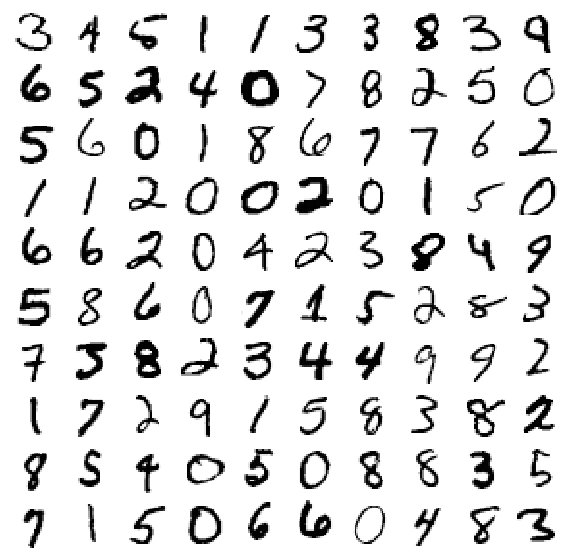

In [7]:
#select few random indices to visualize data
m = ytest.size
rand_indices = np.random.choice(m, 100, replace=False)
sel = Xtest[rand_indices, :]
displayData(sel)

In [8]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


In [9]:
num_labels = len(set(ytrain)) 
options= {'maxiter': 5000}
lambda_ = 1.5
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, Xtrain, ytrain, lambda_)

#costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [10]:
#Test trained network on validation and test sets

predTrain,_ = predict(Theta1, Theta2, Xtrain)
print('Training Set Accuracy: %f' % (np.mean(predTrain == ytrain) * 100))

predCV,_ = predict(Theta1, Theta2, Xval)
print('Validation Set Accuracy: %f' % (np.mean(predCV == yval) * 100))

predTest,_ = predict(Theta1, Theta2, Xtest)
print('Test Set Accuracy: %f' % (np.mean(predTest == ytest) * 100))

Training Set Accuracy: 93.680380
Validation Set Accuracy: 89.925000
Test Set Accuracy: 90.629063


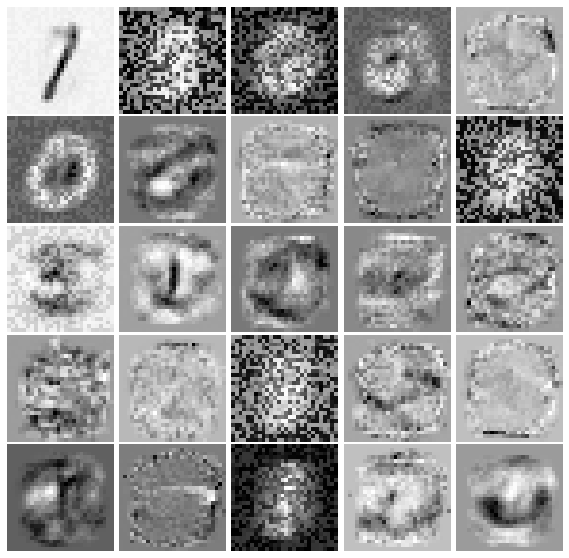

In [1]:
#Visualizing the hidden layer

displayData(Theta1[:, 1:])

In [11]:
#save the trained theta values

np.savetxt('Theta1.csv', Theta1)
np.savetxt('Theta2.csv', Theta1)

In [1]:
#GUI to draw and predict numbers using trained Theta matrices

from tkinter import *
from PIL import Image, ImageDraw

def paint( event ):
    """
    Draws a small black circle at the current location
    if mouse pressed.
    
    """
    python_black = "#000000"
    xLoc = (event.x if event.x<280 else 279)
    yLoc = (event.y if event.y<280 else 279)
    x1, y1 = ( xLoc - 3 ), ( yLoc - 3 )
    x2, y2 = ( xLoc + 3 ), ( yLoc + 3 )
    
    #draw circle around selected pixel
    w.create_oval( x1, y1, x2, y2, fill = python_black)
    
    #make corresponding pixel black in the matrix
    M[int((xLoc+5)/10), int((yLoc+5)/10)] = 255 

def drawRect():
    w.create_line(3, 3,                 # origin of canvas
              3, 280, # coordinates of left upper corner of the box[0]
              fill="#000000", 
              width=3)

    w.create_line(3, 3,                 # origin of canvas
              280, 3, # coordinates of left upper corner of the box[0]
              fill="#000000", 
              width=3)

    w.create_line(280, 3,                 # origin of canvas
              280, 280, # coordinates of left upper corner of the box[0]
              fill="#000000", 
              width=3)

    w.create_line(280, 280,                 # origin of canvas
              3, 280, # coordinates of left upper corner of the box[0]
              fill="#000000", 
              width=3)

def pred():
    """
    Make prediction with corresponding probability using the matrix
    representing the drawing
    
    """
    global M
    prediction, prob = predict(Theta1, Theta2, M.ravel()[None])
    w.create_text(140, 260,
                  text = ("I predict {} with {}% certainty".format(sum(prediction), (int(prob*100)))))

def clr():
    """
    Clear screen and reset the drawing matrix
    
    """
    w.delete('all')
    global M 
    M= np.zeros((28,28))
    drawRect()

canvas_width = 280
canvas_height = 280

#create matrix to store pixel values
M= np.zeros((28,28))

master = Tk()
master.title( "Write any number" )
w = Canvas(master, 
           width=canvas_width, 
           height=canvas_height)
w.pack(expand = NO, fill = BOTH)
w.bind( "<B1-Motion>", paint )

drawRect()

b = Button(master, text="Predict", command=pred)
b.pack()
c = Button(master, text="Clear", command=clr)
c.pack()

mainloop()

C:\Users\Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
